# Feedforward Neural Network on GPU (Minimal)

Using the MNIST-Fashion dataset.

- [Data](#data)
- [Model](#model)
- [Using GPU](#gpu)
- [Training](#training)
- [Predict](#predict)
- [Save](#save)


<div id="xx" />

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

<div id="data" />

## Data

In [2]:
dataset = FashionMNIST(
    root="../data/pytorch_data",
    download=True,
    transform=ToTensor()
)
test_dataset = FashionMNIST(
    root="../data/pytorch_data",
    train=False,
    transform=ToTensor()
)

0it [00:00, ?it/s]

26427392it [00:03, 8037371.53it/s]                               


Extracting ../data/pytorch_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/29515 [00:00<?, ?it/s]

32768it [00:00, 160969.66it/s]           
  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/pytorch_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 5694463.40it/s]                             
0it [00:00, ?it/s]

Extracting ../data/pytorch_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51532.55it/s]            


Extracting ../data/pytorch_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size = 128
train_loader = DataLoader(
    train_ds,
    batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size*2,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size*2,
    num_workers=4,
    pin_memory=True
)

images.shape: torch.Size([128, 1, 28, 28])


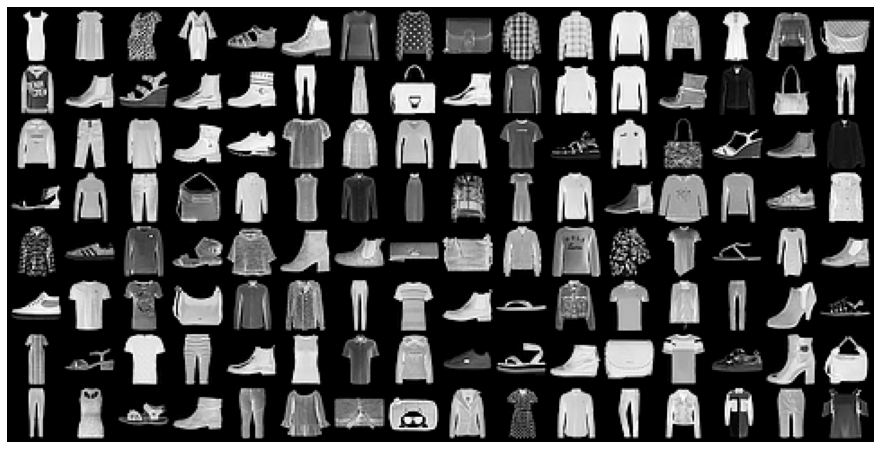

In [5]:
for images, _ in train_loader:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16,8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<div id="model" />

## Model

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 32)
        # hidden layer 2
        self.linear2 = nn.Linear(32, 16)
        # output layer
        self.linear3 = nn.Linear(16, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {"val_loss": loss, "val_acc": acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["val_loss"], result["val_acc"]))

<div id="gpu" />

## Using GPU

In [8]:
torch.cuda.is_available()

False

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [10]:
device = get_default_device()
device

device(type='cpu')

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

<div id="training" />

## Training

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
input_size = 784
num_classes = 10

In [16]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=10, bias=True)
)

In [17]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.318934679031372, 'val_acc': 0.09658203274011612}]

In [18]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6347, val_acc: 0.7276
Epoch [1], val_loss: 0.7198, val_acc: 0.7288
Epoch [2], val_loss: 0.6045, val_acc: 0.7922
Epoch [3], val_loss: 0.4836, val_acc: 0.8293
Epoch [4], val_loss: 0.4583, val_acc: 0.8317


In [19]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4065, val_acc: 0.8539
Epoch [1], val_loss: 0.3944, val_acc: 0.8599
Epoch [2], val_loss: 0.3886, val_acc: 0.8606
Epoch [3], val_loss: 0.3848, val_acc: 0.8604
Epoch [4], val_loss: 0.3856, val_acc: 0.8586


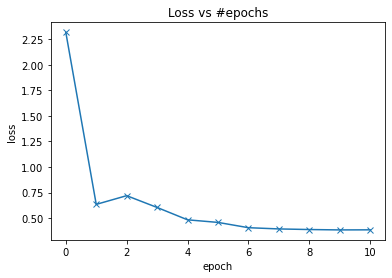

In [20]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs #epochs");

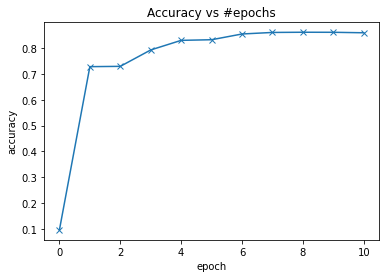

In [21]:
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs #epochs");

<div id="predict" />

## Predict

In [22]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


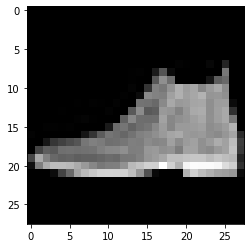

In [23]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap="gray")
print("Label:", dataset.classes[label], ", Predicted:", dataset.classes[predict_image(img, model)])

In [24]:
evaluate(model, test_loader)

{'val_loss': 0.41769862174987793, 'val_acc': 0.848828136920929}

<div id="save" />

## Save

In [25]:
saved_weights_fname = "models/fashion-feedforward.pth"
torch.save(model.state_dict(), saved_weights_fname)